In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
class SuggestionClassifier:
    """A classifier that identifies suggestions in text."""
    
    def __init__(self):
        """Initialize the classifier."""
        # Load spaCy model for text processing
        self.nlp = spacy.load('en_core_web_sm')
        
        # Initialize TF-IDF vectorizer
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        
        # Initialize classifier
        self.clf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Suggestion patterns and keywords
        self.suggestion_patterns = [
            r"\bshould\b",
            r"\bcould\b",
            r"\bwould be nice\b",
            r"\bwould be better\b",
            r"\bneed to\b",
            r"\bneeds to\b",
            r"\bmight want to\b",
            r"\bhow about\b",
            r"\bwhy not\b",
            r"\bsuggest\b",
            r"\brecommend\b",
            r"\bwish\b",
            r"\bhope\b",
            r"\bif only\b",
            r"\bconsider\b",
            r"\bmay want to\b",
            r"\bwould like\b",
            r"\bimprove\b",
            r"\bupgrade\b",
            r"\badd\b",
            r"\bchange\b",
            r"\bprovide\b"
        ]
        
        # Compile patterns for faster matching
        self.compiled_patterns = [re.compile(pattern, re.IGNORECASE) for pattern in self.suggestion_patterns]
        
        # Is the model fitted?
        self.is_fitted = False
    
    def preprocess(self, text):
        """Clean and normalize text"""
        # Convert to lowercase and strip whitespace
        text = text.lower().strip()
        
        # Process with spaCy
        doc = self.nlp(text)
        
        # Extract lemmatized tokens, excluding stopwords and punctuation
        tokens = [token.lemma_ for token in doc 
                 if not token.is_stop and not token.is_punct]
        
        return " ".join(tokens)
    
    def _create_labeled_data(self, texts):
        """Create weakly labeled data based on pattern matching."""
        X = []
        y = []
        
        for text in texts:
            processed_text = self.preprocess(text)
            X.append(processed_text)
            
            # Check if any pattern matches
            is_suggestion = 0
            for pattern in self.compiled_patterns:
                if pattern.search(text.lower()):
                    is_suggestion = 1
                    break
            
            y.append(is_suggestion)
        
        return X, y
    
    def fit_unsupervised(self, texts):
        """Train the classifier using weak supervision."""
        X, y = self._create_labeled_data(texts)
        
        # Transform text data into TF-IDF features
        X_tfidf = self.vectorizer.fit_transform(X)
        
        # Train the classifier
        self.clf.fit(X_tfidf, y)
        self.is_fitted = True
        
        # Return the proportion of suggestions found for reference
        return sum(y) / len(y)
    
    def predict(self, text, threshold=0.5):
        """Predict if a text contains a suggestion."""
        if not self.is_fitted:
            raise ValueError("The classifier has not been trained yet. Call fit_unsupervised first.")
        
        # Get the probability and compare with threshold
        prob = self.predict_proba(text)
        return prob >= threshold
    
    def predict_proba(self, text):
        """Get the probability that a text contains a suggestion."""
        if not self.is_fitted:
            raise ValueError("The classifier has not been trained yet. Call fit_unsupervised first.")
        
        processed_text = self.preprocess(text)
        X_tfidf = self.vectorizer.transform([processed_text])
        
        # Get the probability of the positive class (suggestion)
        proba = self.clf.predict_proba(X_tfidf)[0, 1]
        return proba
    
    def evaluate(self, texts, true_labels):
        """Evaluate the classifier on labeled data."""
        if not self.is_fitted:
            raise ValueError("The classifier has not been trained yet. Call fit_unsupervised first.")
        
        predictions = [self.predict(text) for text in texts]
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        conf_matrix = confusion_matrix(true_labels, predictions)
        
        return {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': conf_matrix
        }

In [6]:
def create_sample_dataset():
    """Create a synthetic dataset of restaurant reviews with suggestions and non-suggestions."""
    
    suggestion_reviews = [
        "They should offer more vegetarian options on the menu.",
        "I wish they had more parking spaces available.",
        "You could improve the lighting, it was too dark to read the menu.",
        "The restaurant should consider extending their hours on weekends.",
        "They need to improve their service speed during peak hours.",
        "It would be nice if they offered free wifi for customers.",
        "The management should train their staff to be more attentive.",
        "Consider adding more spicy options to cater to different tastes.",
        "They could benefit from having a kids' menu available.",
        "Why not add some live music on Friday nights?",
        "The restaurant should update their menu seasonally.",
        "The owners might want to renovate the outdoor seating area.",
        "They should offer a loyalty program for regular customers.",
        "It would be helpful if they listed allergens clearly on the menu.",
        "The chef could use less salt in the pasta dishes.",
        "I recommend adding more dessert options to the menu.",
        "The restaurant needs better ventilation in the dining area.",
        "They should consider adding online reservation options.",
        "The management could improve the acoustic design to reduce noise.",
        "They ought to invest in more comfortable seating.",
        "I hope they'll add more vegan dishes soon.",
        "Maybe they could offer cooking classes on weekends?",
        "The restaurant would benefit from having a digital menu board.",
        "Consider hiring more staff for weekend shifts.",
        "The waiting area should be expanded for busy nights.",
        "If only they would add more beer options to their drinks menu.",
        "The bathroom facilities need to be upgraded.",
        "They should make their entrance more wheelchair accessible.",
        "It would be nice if they offered a prix fixe menu for special occasions.",
        "The management should consider adding a coat check during winter."
    ]

    non_suggestion_reviews = [
        "The food was excellent, I would recommend this place.",
        "The service was slow and the restaurant was too noisy.",
        "The pizza crust was perfect, crispy on the outside and soft inside.",
        "I had the best pasta dish I've ever tasted here.",
        "The ambiance was cozy and romantic, perfect for our anniversary.",
        "Our waiter was very attentive and knowledgeable about the menu.",
        "The prices were reasonable for the quality of food served.",
        "I was disappointed with the portion sizes given the price.",
        "The wine selection complemented the menu perfectly.",
        "We waited over an hour for our main course to arrive.",
        "The steak was cooked exactly as I ordered, medium-rare.",
        "The dessert menu had so many tempting options.",
        "Our table had a beautiful view of the sunset.",
        "The manager was very apologetic about the mix-up with our reservation.",
        "I loved the seasonal ingredients used in their specials.",
        "The chicken was dry and lacked flavor.",
        "The cocktails were creative and beautifully presented.",
        "We enjoyed the live piano music during dinner.",
        "The seafood tasted incredibly fresh and well-prepared.",
        "The restaurant was too cold, we had to keep our jackets on.",
        "I appreciate that they source their ingredients locally.",
        "The birthday dessert they brought out was a nice surprise.",
        "The outdoor patio was perfect for brunch on a sunny day.",
        "The staff handled the large group efficiently.",
        "I found a hair in my soup and lost my appetite.",
        "The restaurant has a great selection of craft beers.",
        "We've been coming here for years and the quality remains consistent.",
        "The new chef has really improved the menu since our last visit.",
        "The spicy dishes weren't as hot as advertised.",
        "The vegetarian options were creative and not just afterthoughts."
    ]

    # Combine all reviews
    all_reviews = suggestion_reviews + non_suggestion_reviews

    # Create true labels (1 for suggestions, 0 for non-suggestions)
    true_labels = [1] * len(suggestion_reviews) + [0] * len(non_suggestion_reviews)

    # Create a DataFrame for better organization
    reviews_df = pd.DataFrame({
        'review': all_reviews,
        'is_suggestion': true_labels
    })
    
    return reviews_df


def train_and_evaluate_model(reviews_df):
    """Train the suggestion classifier and evaluate its performance."""
    
    # Initialize classifier
    classifier = SuggestionClassifier()

    # Train the classifier
    suggestion_rate = classifier.fit_unsupervised(reviews_df['review'].tolist())
    
    print(f"Training complete!")
    print(f"Detected suggestion rate during training: {suggestion_rate:.2f} "
          f"({int(suggestion_rate * len(reviews_df))} out of {len(reviews_df)} reviews)")
    
    # Evaluate the classifier
    results = []
    for _, row in reviews_df.iterrows():
        review = row['review']
        true_label = row['is_suggestion']
        
        # Get prediction and probability
        probability = classifier.predict_proba(review)
        predicted = classifier.predict(review, threshold=0.5)
        
        results.append({
            "review": review,
            "true_label": true_label,
            "probability": probability,
            "predicted": predicted,
            "correct": predicted == true_label
        })

    # Convert to DataFrame
    eval_df = pd.DataFrame(results)

    # Calculate accuracy
    accuracy = eval_df['correct'].mean()
    print(f"Accuracy: {accuracy:.2f}")

    # Display confusion matrix
    conf_matrix = confusion_matrix(eval_df['true_label'], eval_df['predicted'])
    labels = ['Non-suggestion', 'Suggestion']

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(eval_df['true_label'], eval_df['predicted'], target_names=labels))
    
    return classifier, eval_df


In [7]:
def analyze_prediction_probabilities(eval_df):
    """Visualize the distribution of prediction probabilities."""
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=eval_df, x='probability', hue='true_label', bins=20, alpha=0.7)
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold (0.5)')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend(['Threshold (0.5)', 'Non-suggestion', 'Suggestion'])
    plt.show()


def examine_misclassifications(eval_df):
    """Analyze reviews that were misclassified by the model."""
    
    # Find misclassified reviews
    misclassified = eval_df[~eval_df['correct']].copy()

    # Add error type
    misclassified['error_type'] = misclassified.apply(
        lambda x: 'False Positive' if x['predicted'] == 1 and x['true_label'] == 0 else 'False Negative', 
        axis=1
    )

    # Sort by probability
    misclassified = misclassified.sort_values('probability', ascending=False)

    # Display misclassified reviews
    print(f"Total misclassified reviews: {len(misclassified)} out of {len(eval_df)} "
          f"({len(misclassified)/len(eval_df):.2%})")
    print("\nMisclassified Reviews:")
    print(misclassified[['review', 'error_type', 'probability']])
    
    return misclassified

In [8]:
def optimize_threshold(classifier, reviews_df):
    """Find the optimal threshold value for classification."""
    
    # Try different thresholds
    thresholds = np.linspace(0.1, 0.9, 17)
    threshold_results = []

    for threshold in thresholds:
        # Apply threshold
        predictions = [classifier.predict(review, threshold=threshold) for review in reviews_df['review']]
        
        # Calculate metrics
        accuracy = accuracy_score(reviews_df['is_suggestion'], predictions)
        report = classification_report(reviews_df['is_suggestion'], predictions, output_dict=True)
        
        threshold_results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1': report['1']['f1-score']
        })

    # Convert to DataFrame
    threshold_df = pd.DataFrame(threshold_results)

    # Find optimal threshold based on F1 score
    optimal_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
    print(f"Optimal threshold based on F1 score: {optimal_threshold:.2f}")

    # Plot metrics vs threshold
    plt.figure(figsize=(12, 6))
    plt.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o', label='Accuracy')
    plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='Precision')
    plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='Recall')
    plt.plot(threshold_df['threshold'], threshold_df['f1'], marker='d', label='F1 Score')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
    plt.text(optimal_threshold+0.02, 0.5, f'Optimal Threshold: {optimal_threshold:.2f}', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Classification Metrics vs. Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return optimal_threshold

In [ ]:
def save_model(classifier, filename='fitted_suggestion_classifier.pkl'):
    """Save the trained model to a pickle file."""
    
    with open(filename, 'wb') as f:
        pickle.dump(classifier, f)

    print(f"Model saved to '{filename}'")


def test_with_new_data(classifier, optimal_threshold):
    """Test the classifier with new reviews."""
    
    # Test with new reviews
    new_reviews = [
        "The chef should consider offering a tasting menu option.",
        "We had an amazing dinner and will definitely come back.",
        "Perhaps adding some more lighting near the bar area would be good.",
        "The wine pairing was excellent with our meal.",
        "I think they need more staff during the lunch rush.",
        "Our server John was extremely knowledgeable and friendly.",
        "Have you thought about adding gluten-free bread options?",
        "The new seasonal menu has some great choices.",
        "overpirced and not worth it, lower prices would be nice",
    ]

    # Use the optimal threshold from our analysis
    test_results = []
    for review in new_reviews:
        probability = classifier.predict_proba(review)
        is_suggestion = classifier.predict(review, threshold=optimal_threshold)
        test_results.append({
            "review": review,
            "probability": probability,
            "is_suggestion": is_suggestion
        })

    # Display results
    test_df = pd.DataFrame(test_results)
    print("New Review Classification Results:")
    print("-" * 50)
    for _, row in test_df.iterrows():
        print(f"Review: {row['review']}")
        print(f"Suggestion probability: {row['probability']:.2f}")
        print(f"Is suggestion: {'Yes' if row['is_suggestion'] else 'No'}")
        print("-" * 50)

    print(f"\nTotal reviews: {len(test_df)}")
    print(f"Suggestions detected: {test_df['is_suggestion'].sum()}")
    print(f"Detection rate: {test_df['is_suggestion'].mean()*100:.1f}%")
    
    return test_df


def analyze_feature_importance(classifier):
    """Analyze which features are most important for making predictions."""
    
    feature_names = classifier.vectorizer.get_feature_names_out()

    importances = classifier.clf.feature_importances_


    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("Top 20 Most Important Features:")
    print(feature_importance_df.head(20))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df


def integrate_with_project_rest(reviews_df, classifier, threshold=0.3):
    """
    Process a DataFrame of reviews to extract suggestions and organize them by topic.
    
    Args:
        reviews_df: DataFrame with review data (must have 'review_text' column)
        classifier: Trained SuggestionClassifier
        threshold: Threshold for suggestion classification
        
    Returns:
        DataFrame with processed suggestions
    """

    processed_df = reviews_df.copy()
    
    # Classify suggestions
    processed_df['suggestion_probability'] = processed_df['review_text'].apply(classifier.predict_proba)
    processed_df['is_suggestion'] = processed_df['suggestion_probability'].apply(lambda x: x >= threshold)
    
    # Filter to only suggestions
    suggestions_df = processed_df[processed_df['is_suggestion']].copy()
    
    # Use spaCy for additional NLP analysis on suggestions
    nlp = classifier.nlp
    
    # Extract key topics and entities from suggestions
    topics = []
    entities = []
    
    for review in suggestions_df['review_text']:
        doc = nlp(review)
        
        # Extract noun chunks as potential topics
        review_topics = [chunk.text.lower() for chunk in doc.noun_chunks 
                        if not all(token.is_stop for token in chunk)]
        
        # Extract named entities
        review_entities = [(ent.text, ent.label_) for ent in doc.ents]
        
        topics.append(review_topics)
        entities.append(review_entities)
    
    suggestions_df['extracted_topics'] = topics
    suggestions_df['extracted_entities'] = entities
    
    return suggestions_df


def complete_workflow_example(new_review_text, classifier_path='fitted_suggestion_classifier.pkl', threshold=None):
    """
    Demonstrates a complete workflow from loading the model to making predictions on new text.
    
    Args:
        new_review_text: Text of a new review to classify
        classifier_path: Path to the saved classifier
        threshold: Classification threshold (if None, will use 0.5)
        
    Returns:
        Dictionary with classification results
    """
    try:
        # Load the classifier
        with open(classifier_path, 'rb') as f:
            classifier = pickle.load(f)
            
        # Apply threshold
        threshold = threshold or 0.5
        
        # Process the review
        probability = classifier.predict_proba(new_review_text)
        is_suggestion = classifier.predict(new_review_text, threshold=threshold)
        
        # Extract additional information
        doc = classifier.nlp(new_review_text)
        
        # Extract topics
        topics = [chunk.text for chunk in doc.noun_chunks 
                if not all(token.is_stop for token in chunk)]
        
        # Create result
        result = {
            'review': new_review_text,
            'suggestion_probability': probability,
            'is_suggestion': is_suggestion,
            'topics': topics,
            'preprocessed_text': classifier.preprocess(new_review_text)
        }
        
        return result
    
    except Exception as e:
        return {'error': str(e)}

In [13]:
def main():
    """Main function to demonstrate the full workflow."""
    
    print("Restaurant Review Suggestion Classifier")
    print("=" * 50)
    print("\nThis script demonstrates a classifier that identifies customer suggestions")
    print("within restaurant reviews to help restaurant owners automatically extract")
    print("actionable feedback from customer comments.\n")
    

    print("\n1. Creating sample dataset...")
    reviews_df = create_sample_dataset()
    print(f"Total reviews: {len(reviews_df)}")
    print(f"Suggestions: {reviews_df['is_suggestion'].sum()}")
    print(f"Non-suggestions: {len(reviews_df) - reviews_df['is_suggestion'].sum()}")
    print("Sample reviews:")
    print(reviews_df.sample(5))
    

    print("\n2. Training and evaluating the model...")
    classifier, eval_df = train_and_evaluate_model(reviews_df)
    

    print("\n3. Analyzing prediction probabilities...")
    analyze_prediction_probabilities(eval_df)
    

    print("\n4. Examining misclassifications...")
    misclassified = examine_misclassifications(eval_df)
    

    print("\n5. Optimizing the classification threshold...")
    optimal_threshold = optimize_threshold(classifier, reviews_df)
    

    print("\n6. Saving the model...")
    save_model(classifier)
    

    print("\n7. Testing with new data...")
    test_df = test_with_new_data(classifier, optimal_threshold)
    

    print("\n8. Analyzing feature importance...")
    feature_importance_df = analyze_feature_importance(classifier)
    

    print("\n9. Example of using the complete workflow function:")
    sample_review = "The restaurant should consider adding more healthy options to their menu."
    result = complete_workflow_example(
        sample_review,
        classifier_path='fitted_suggestion_classifier.pkl',
        threshold=optimal_threshold
    )
    print(f"Review: {result['review']}")
    print(f"Suggestion probability: {result['suggestion_probability']:.2f}")
    print(f"Is suggestion: {'Yes' if result['is_suggestion'] else 'No'}")
    print(f"Topics: {', '.join(result['topics'])}")
    print(f"Preprocessed text: {result['preprocessed_text']}")
    
    print("\nDone!")

Restaurant Review Suggestion Classifier

This script demonstrates a classifier that identifies customer suggestions
within restaurant reviews to help restaurant owners automatically extract
actionable feedback from customer comments.


1. Creating sample dataset...
Total reviews: 60
Suggestions: 30
Non-suggestions: 30
Sample reviews:
                                               review  is_suggestion
19  They ought to invest in more comfortable seating.              1
0   They should offer more vegetarian options on t...              1
18  The management could improve the acoustic desi...              1
6   The management should train their staff to be ...              1
49  The restaurant was too cold, we had to keep ou...              0

2. Training and evaluating the model...
Training complete!
Detected suggestion rate during training: 0.45 (27 out of 60 reviews)
Accuracy: 0.92


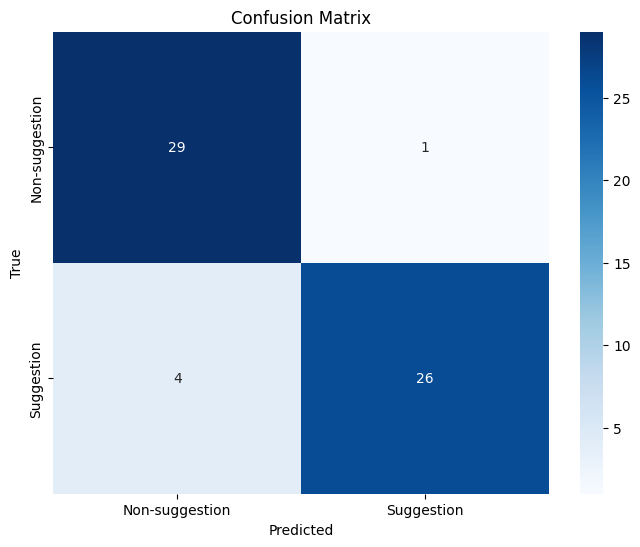


Classification Report:
                precision    recall  f1-score   support

Non-suggestion       0.88      0.97      0.92        30
    Suggestion       0.96      0.87      0.91        30

      accuracy                           0.92        60
     macro avg       0.92      0.92      0.92        60
  weighted avg       0.92      0.92      0.92        60


3. Analyzing prediction probabilities...


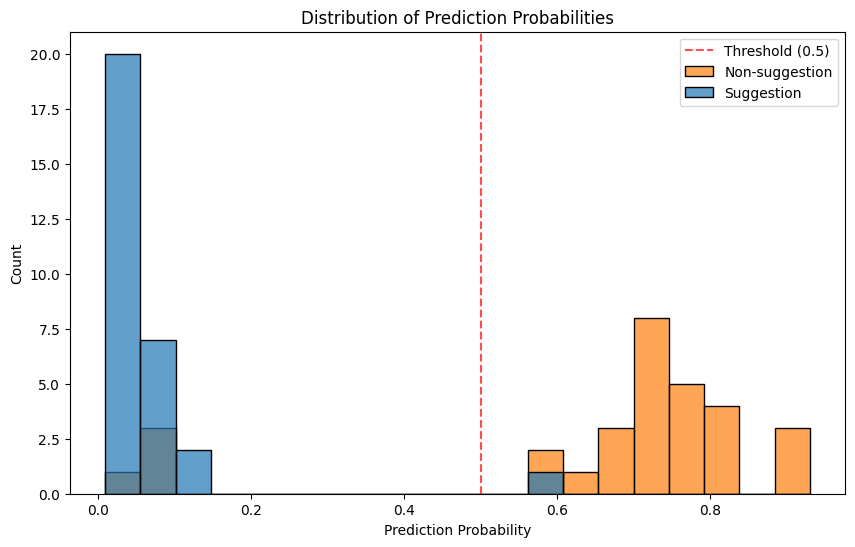


4. Examining misclassifications...
Total misclassified reviews: 5 out of 60 (8.33%)

Misclassified Reviews:
                                               review      error_type  \
30  The food was excellent, I would recommend this...  False Positive   
16  The restaurant needs better ventilation in the...  False Negative   
22  The restaurant would benefit from having a dig...  False Negative   
19  They ought to invest in more comfortable seating.  False Negative   
13  It would be helpful if they listed allergens c...  False Negative   

    probability  
30         0.60  
16         0.09  
22         0.07  
19         0.06  
13         0.02  

5. Optimizing the classification threshold...
Optimal threshold based on F1 score: 0.15


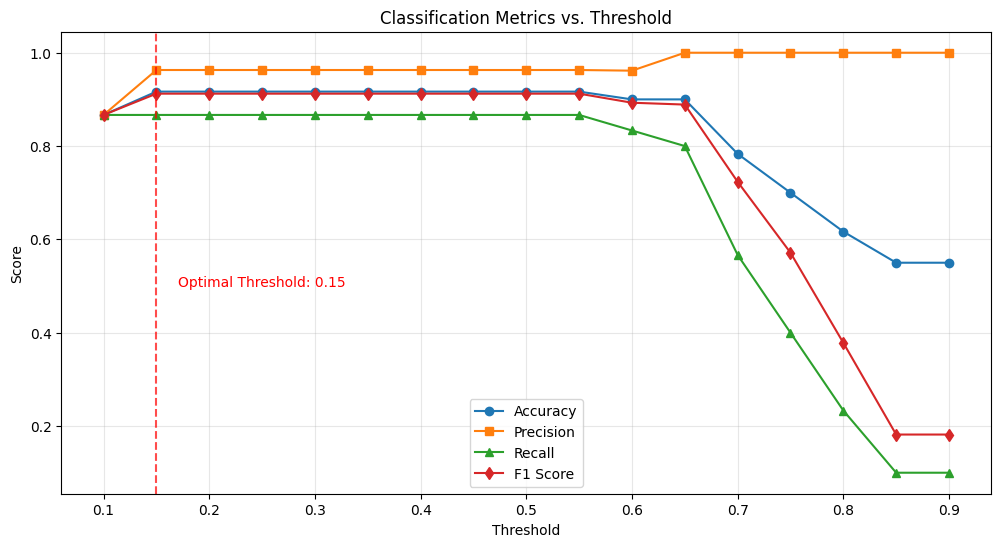


6. Saving the model...
Model saved to 'fitted_suggestion_classifier.pkl'

7. Testing with new data...
New Review Classification Results:
--------------------------------------------------
Review: The chef should consider offering a tasting menu option.
Suggestion probability: 0.73
Is suggestion: Yes
--------------------------------------------------
Review: We had an amazing dinner and will definitely come back.
Suggestion probability: 0.04
Is suggestion: No
--------------------------------------------------
Review: Perhaps adding some more lighting near the bar area would be good.
Suggestion probability: 0.54
Is suggestion: Yes
--------------------------------------------------
Review: The wine pairing was excellent with our meal.
Suggestion probability: 0.14
Is suggestion: No
--------------------------------------------------
Review: I think they need more staff during the lunch rush.
Suggestion probability: 0.39
Is suggestion: Yes
--------------------------------------------------


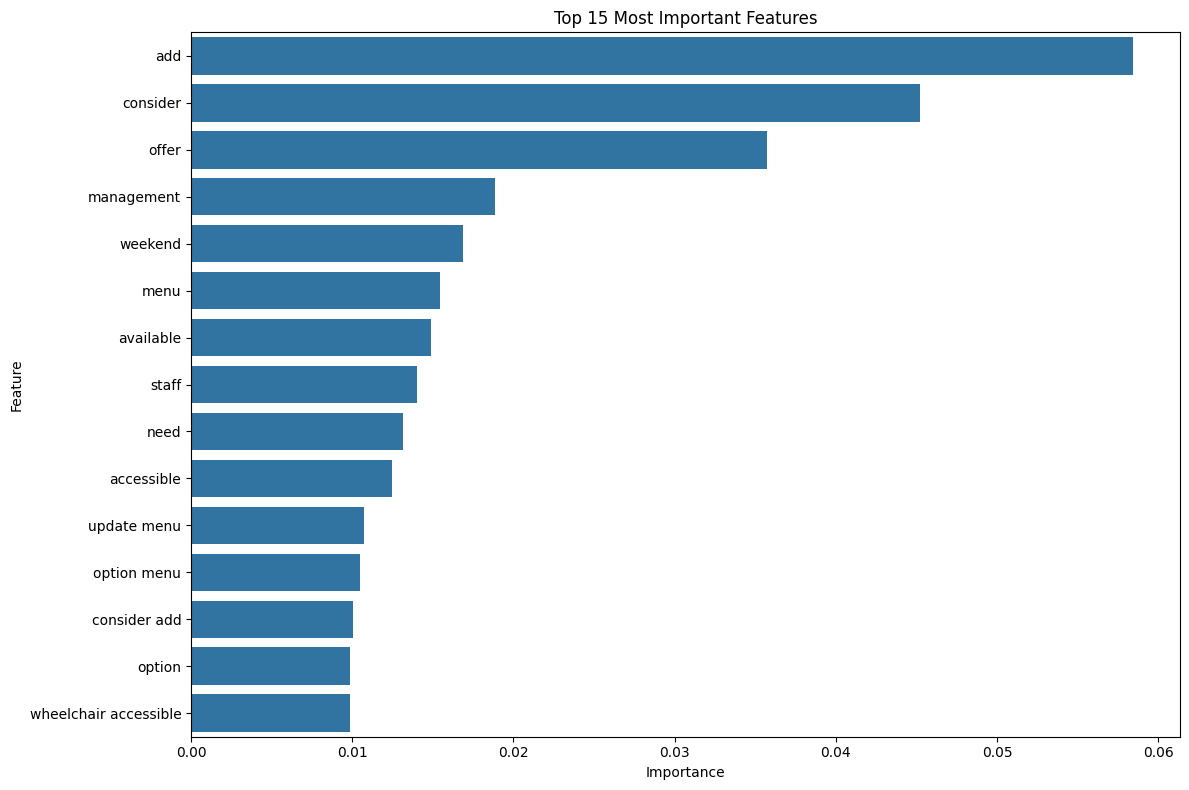


9. Example of using the complete workflow function:
Review: The restaurant should consider adding more healthy options to their menu.
Suggestion probability: 0.85
Is suggestion: Yes
Topics: The restaurant, more healthy options, their menu
Preprocessed text: restaurant consider add healthy option menu

Done!


In [14]:
main()